# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [26]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc, col
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import lit

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [6]:
df.count()

286500

In [7]:
# Clean - require valid userId & sessionId
clean_df = df.dropna(how = "any", subset = ["userId", "sessionId"]) # Note: there were no NaNs seen in data sample
clean_df = clean_df.filter(clean_df["userId"] != "") # Drop empty string userId
clean_df.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|             

In [8]:
clean_df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# Look at distinct page values
clean_df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [10]:
# Define a "churn" event to be when 'Cancellation Confirmation' page is visited
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
clean_df = clean_df.withColumn("churned", flag_churn_event("page"))
clean_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churned=0)

In [11]:
# Similarly track "downgrade" events
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
clean_df = clean_df.withColumn("downgraded", flag_downgrade_event("page"))
clean_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churned=0, downgraded=0)

In [12]:
# Pull out hour from millisecond ts
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
clean_df = clean_df.withColumn("hour", get_hour("ts"))
clean_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churned=0, downgraded=0, hour=0)

In [13]:
# Time since registration
days_active = udf(lambda x,y: float((x-y)/(86400000.0)), FloatType())
clean_df = clean_df.withColumn("DaysSinceRegistration", days_active("ts", "registration"))

# Look at distribution of time for accounts
clean_df.describe("DaysSinceRegistration").show()

+-------+---------------------+
|summary|DaysSinceRegistration|
+-------+---------------------+
|  count|               278154|
|   mean|    64.81575632214941|
| stddev|   41.993367597600084|
|    min|           -2.2718172|
|    max|             256.3777|
+-------+---------------------+



In [14]:
# Get NonChurn Free User count
print("NonChurn Free Users")
clean_df.createOrReplaceTempView("myView")
ret_val = spark.sql('''SELECT COUNT(DISTINCT userId) as free_user_count FROM myView 
WHERE level="free" AND userId NOT IN (SELECT DISTINCT userId FROM myView WHERE churned=1)''').collect()
nonchurned_free_count = ret_val[0]["free_user_count"]
print(nonchurned_free_count)

# Get avg plays per hour for NonChurn Free Users
clean_df.createOrReplaceTempView("myView")
query = 'SELECT hour, COUNT(*)/{} AS avg_plays_per_hour FROM myView \
WHERE page="NextSong" AND level="free" AND userId NOT IN \
(SELECT DISTINCT userId FROM myView WHERE churned=1) \
GROUP BY hour ORDER BY hour'.format(nonchurned_free_count)
print(query)

nonchurn_free_pph = spark.sql(query)
nonchurn_free_pph_pd = nonchurn_free_pph.toPandas()
nonchurn_free_pph_pd

NonChurn Free Users
149
SELECT hour, COUNT(*)/149 AS avg_plays_per_hour FROM myView WHERE page="NextSong" AND level="free" AND userId NOT IN (SELECT DISTINCT userId FROM myView WHERE churned=1) GROUP BY hour ORDER BY hour


,hour,avg_plays_per_hour
0,0,7.906040
1,1,7.469799
2,2,7.422819
3,3,7.731544
4,4,7.577181
5,5,7.536913
6,6,7.523490
7,7,7.040268
8,8,6.617450
9,9,7.442953


In [15]:
# Get count of NonChurn Paid Users
print("NonChurn Paid Users")
clean_df.createOrReplaceTempView("myView")
ret_val = spark.sql('''SELECT COUNT(DISTINCT userId) as paid_user_count FROM myView 
WHERE level="paid" AND userId NOT IN (SELECT DISTINCT userId FROM myView WHERE churned=1)''').collect()
nonchurned_paid_count = ret_val[0]["paid_user_count"]
print(nonchurned_paid_count)

# Get avg plays per hour for NonChurn Paid Users
clean_df.createOrReplaceTempView("myView")
query = 'SELECT hour, COUNT(*)/{} AS avg_plays_per_hour FROM myView \
WHERE page="NextSong" AND level="paid" AND userId NOT IN \
(SELECT DISTINCT userId FROM myView WHERE churned=1) \
GROUP BY hour ORDER BY hour'.format(nonchurned_paid_count)

nonchurn_paid_pph = spark.sql(query)
nonchurn_paid_pph_pd = nonchurn_paid_pph.toPandas()
nonchurn_paid_pph_pd

NonChurn Paid Users
129


,hour,avg_plays_per_hour
0,0,49.217054
1,1,45.906977
2,2,45.798450
3,3,45.821705
4,4,44.844961
5,5,45.248062
6,6,44.302326
7,7,45.147287
8,8,46.798450
9,9,47.744186


In [16]:
# Get downgraded user count
print("Downgrade Users")
clean_df.createOrReplaceTempView("myView")
ret_val = spark.sql('''
          SELECT COUNT(DISTINCT userId) as downgrade_user_count FROM myView WHERE downgraded=1
          '''
          ).collect()
downgrade_user_count = ret_val[0]["downgrade_user_count"]
print(downgrade_user_count)

# Get avg plays per hour for Downgrade Users
clean_df.createOrReplaceTempView("myView")
query = 'SELECT hour, COUNT(*)/{} AS avg_plays_per_hour FROM myView \
WHERE page="NextSong" AND userId IN \
(SELECT DISTINCT userId FROM myView WHERE downgraded=1) \
GROUP BY hour ORDER BY hour'.format(downgrade_user_count)

downgrade_pph = spark.sql(query)
downgrade_pph_pd = downgrade_pph.toPandas()
downgrade_pph_pd

Downgrade Users
49


,hour,avg_plays_per_hour
0,0,68.795918
1,1,62.795918
2,2,63.510204
3,3,64.755102
4,4,64.795918
5,5,66.306122
6,6,63.040816
7,7,62.816327
8,8,63.979592
9,9,63.530612


In [17]:
# Get Free Churn User Count
print("Churn Free Users")
clean_df.createOrReplaceTempView("myView")
ret_val = spark.sql('''
          SELECT COUNT(DISTINCT userId) as churned_free_count FROM myView WHERE churned=1 and level="free"
          '''
          ).collect()
churned_free_count = ret_val[0]["churned_free_count"]
print(churned_free_count)

# Get Avg Plays Per Hour from Free Churn Users
clean_df.createOrReplaceTempView("myView")
query = 'SELECT hour, COUNT(*)/{} AS avg_plays_per_hour FROM myView \
    WHERE page="NextSong" AND userId IN \
    (SELECT DISTINCT userId FROM myView WHERE churned=1 and level="free") \
    GROUP BY hour ORDER BY hour'.format(churned_free_count)

free_churn_pph = spark.sql(query)
free_churn_pph_pd = free_churn_pph.toPandas()
free_churn_pph_pd

Churn Free Users
21


,hour,avg_plays_per_hour
0,0,7.095238
1,1,6.285714
2,2,7.714286
3,3,6.904762
4,4,7.476190
5,5,7.380952
6,6,9.761905
7,7,10.047619
8,8,9.380952
9,9,8.285714


In [18]:
# Get Paid Churned User count
clean_df.createOrReplaceTempView("myView")
ret_val = spark.sql('''
          SELECT COUNT(DISTINCT userId) as churned_paid_count FROM myView WHERE churned=1 and level="paid"
          '''
          ).collect()
churned_paid_count = ret_val[0]["churned_paid_count"]
print(churned_paid_count)

# Get Avg Plays Per Hour from Paid Churn Users
clean_df.createOrReplaceTempView("myView")
query = 'SELECT hour, COUNT(*)/{} AS avg_plays_per_hour FROM myView \
WHERE page="NextSong" AND userId IN \
(SELECT DISTINCT userId FROM myView WHERE churned=1 and level="paid") \
GROUP BY hour ORDER BY hour'.format(churned_paid_count)

paid_churn_pph = spark.sql(query)
paid_churn_pph_pd = paid_churn_pph.toPandas()
paid_churn_pph_pd

31


,hour,avg_plays_per_hour
0,0,44.709677
1,1,39.387097
2,2,37.419355
3,3,37.000000
4,4,34.709677
5,5,34.290323
6,6,32.677419
7,7,32.483871
8,8,33.322581
9,9,34.064516


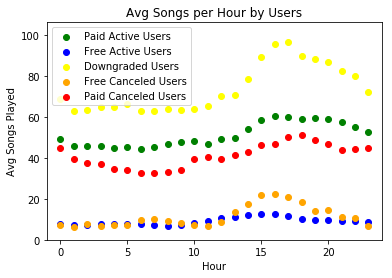

In [19]:
# Scatter plot of average song played per hour per user group type
plt.scatter(nonchurn_paid_pph_pd["hour"], nonchurn_paid_pph_pd["avg_plays_per_hour"], color='green', label="Paid Active Users")
plt.scatter(nonchurn_free_pph_pd["hour"], nonchurn_free_pph_pd["avg_plays_per_hour"], color='blue', label="Free Active Users")
plt.scatter(downgrade_pph_pd["hour"], downgrade_pph_pd["avg_plays_per_hour"], color='yellow', label="Downgraded Users")
plt.scatter(free_churn_pph_pd["hour"], free_churn_pph_pd["avg_plays_per_hour"], color='orange', label="Free Canceled Users")
plt.scatter(paid_churn_pph_pd["hour"], paid_churn_pph_pd["avg_plays_per_hour"], color='red', label="Paid Canceled Users")
plt.xlim(-1, 24)
plt.ylim(0, 1.1 * max(downgrade_pph_pd["avg_plays_per_hour"]))
plt.xlabel("Hour")
plt.ylabel("Avg Songs Played")
plt.title('Avg Songs per Hour by Users')
plt.legend()
plt.show()

**Initial Analysis Based on Songs and User Churn**

From the above we can see that paid users that churn (red) listen about 10-20% less on average than users who don't (green). This is expected- users who are not using the service as regularly are not seeing value and are canceling.

Unexpectedly though, it appears that users who downgrade (yellow) are actually heavy users who listen to about 30-50% more as many songs on average than the average paid user who stays (green). A possible reason could be that heavy users could be drawn to another type of service, so they are downgrading.

Looking about activity for the free user accounts- it initially appears difficult to see a trend corresponding to active vs. cancelled free accounts- free users have much less activity than others.

In the next phase I'll do some additional feature engineering and use a decision tree ensamble (Random Forest) to see if I can get some good seperation among the user classes.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [85]:
# Since most subscriptions are likely monthly based - I'm going to look at activity in a two week period
# And try to predict if there will be churn in the next two week bin
# Also this will help to normalize or smooth out issues that might arise from day to day usage variations (wkends) 
# Note: I can always come back and re-adjust to be something more granular like weekly bins

# UserTimeBin will be the floor of DaysSinceRegistration value divided by 14
user_timebin = udf(lambda x: int(x/14), IntegerType())
clean_df = clean_df.withColumn("UserTimeBin", user_timebin("DaysSinceRegistration"))

# Look at distribution of time for accounts
clean_df.describe("UserTimeBin").show()


# New records should look like:
# UserId | UserTimeBin (continuous Int) | ChurnedInTimeBin (0/1) | DowngradedInTimeBin (0/1) | PrevDowngraded (0/1) |
# SessionCountInTimeBin (continuous Int) | ... 
# Other features to consider:
# Count of visits to each page (one-hot-encode) within UserTimeBin
## Sub-features: page visit count, songs played count, error count, friend adds, playlist adds, help count
# AvgSessionTime, AvgSongsPerSession, etc "Avg" features within UserTimeBin and/or Total
# TotalTimeSinceRegistration (continuous), TotalSessions, etc "Total" features

# To get items in session: Group By sessionId and get max(itemInSession)

+-------+------------------+
|summary|       UserTimeBin|
+-------+------------------+
|  count|            278154|
|   mean|4.1316069515448275|
| stddev| 3.015903664558201|
|    min|                 0|
|    max|                18|
+-------+------------------+



In [86]:
''' For reference:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
'''

' For reference:\nroot\n |-- artist: string (nullable = true)\n |-- auth: string (nullable = true)\n |-- firstName: string (nullable = true)\n |-- gender: string (nullable = true)\n |-- itemInSession: long (nullable = true)\n |-- lastName: string (nullable = true)\n |-- length: double (nullable = true)\n |-- level: string (nullable = true)\n |-- location: string (nullable = true)\n |-- method: string (nullable = true)\n |-- page: string (nullable = true)\n |-- registration: long (nullable = true)\n |-- sessionId: long (nullable = true)\n |-- song: string (nullable = true)\n |-- status: long (nullable = true)\n |-- ts: long (nullable = true)\n |-- userAgent: string (nullable = true)\n |-- userId: string (nullable = true)\n'

In [87]:
# Now add in timebin features - such as whether or not user churned or downgraded in timebin
clean_df.createOrReplaceTempView("myView")
query='''
SELECT UserId, UserTimeBin,
        MAX(IF(level="paid", 1, 0)) AS PaidInTimeBin,
        MAX(IF(level="free", 1, 0)) AS FreeInTimeBin,
        MAX(IF(page="Cancellation Confirmation", 1, 0)) AS ChurnedInTimeBin,  
        MAX(IF(page="Submit Downgrade", 1, 0)) AS DowngradedInTimeBin,
        MAX(IF(page="Submit Upgrade", 1, 0)) AS UpgradedInTimeBin,
        MIN(DaysSinceRegistration) AS DaysRegisteredAtTimeBin
        FROM myView GROUP BY UserId, UserTimeBin 
'''
resulting_df = spark.sql(query)
#resulting_df.describe().show()
resulting_df.show(n=5)


+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+
|   113|          4|            1|            1|               0|                  0|                1|              63.569595|
|    69|          1|            1|            1|               0|                  0|                1|              20.437963|
|300002|          7|            1|            0|               0|                  0|                0|               98.33795|
|   134|          1|            0|            1|               0|                  0|                0|               15.10559|
|   109|          5|            1|            0|               0|                  0|                0| 

In [88]:
resulting_df.createOrReplaceTempView("resultingView")
churnInNextBin_query = '''
SELECT resultingView.UserId, resultingView.UserTimeBin FROM
    resultingView,
    (SELECT UserId, UserTimeBin FROM resultingView WHERE ChurnedInTimeBin=1) AS churnedUserBins
WHERE resultingView.UserId=churnedUserBins.UserId AND resultingView.UserTimeBin=(churnedUserBins.UserTimeBin-1)
'''
churnedInNextBin_df = spark.sql(churnInNextBin_query)
churnedInNextBin_df = churnedInNextBin_df.withColumn("WillChurnInNextBin", lit(1))
churnedInNextBin_df.show(n=5)

+------+-----------+------------------+
|UserId|UserTimeBin|WillChurnInNextBin|
+------+-----------+------------------+
|   143|          3|                 1|
|   105|          1|                 1|
|100023|          1|                 1|
|200020|          4|                 1|
|    53|          2|                 1|
+------+-----------+------------------+
only showing top 5 rows



In [89]:
churnedInNextBin_df.count()

39

In [90]:
resulting_df = resulting_df.join(churnedInNextBin_df, ["UserId","UserTimeBin"], 'left')
resulting_df = resulting_df.na.fill(0)
resulting_df.show(n=10)

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+
|   113|          4|            1|            1|               0|                  0|                1|              63.569595|                 0|
|300002|          7|            1|            0|               0|                  0|                0|               98.33795|                 0|
|    69|          1|            1|            1|               0|                  0|                1|              20.437963|                 0|
|   109|          5|            1|            0|               0|                  0|                0|               

In [91]:
resulting_df.createOrReplaceTempView("resultingView")
prevDowngradedQuery = '''
SELECT resultingView.UserId, resultingView.UserTimeBin FROM 
    resultingView,
    (SELECT UserId, UserTimeBin FROM resultingView WHERE DowngradedInTimeBin=1) AS downgradedUserBins
WHERE resultingView.UserId=downgradedUserBins.UserId AND resultingView.UserTimeBin>downgradedUserBins.UserTimeBin
'''
prevDowngraded_df = spark.sql(prevDowngradedQuery)
prevDowngraded_df = prevDowngraded_df.withColumn("PrevDowngraded", lit(1))
prevDowngraded_df.show(n=5)

+------+-----------+--------------+
|UserId|UserTimeBin|PrevDowngraded|
+------+-----------+--------------+
|    54|          7|             1|
|    54|          6|             1|
|    11|          7|             1|
|    11|          6|             1|
|    11|          8|             1|
+------+-----------+--------------+
only showing top 5 rows



In [92]:
prevDowngraded_df.count()

120

In [93]:
resulting_df = resulting_df.join(prevDowngraded_df, ["UserId","UserTimeBin"], 'left')
resulting_df = resulting_df.na.fill(0)
resulting_df.show(n=5)

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|PrevDowngraded|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+
|   113|          4|            1|            1|               0|                  0|                1|              63.569595|                 0|             0|
|300002|          7|            1|            0|               0|                  0|                0|               98.33795|                 0|             1|
|    69|          1|            1|            1|               0|                  0|                1|              20.437963|                 0|             0|
|   109|          5|        

In [94]:
resulting_df.count() # TODO: debug why there are 4 more rows??

861

In [95]:
page_df = clean_df.groupBy("UserId","UserTimeBin").pivot("page").count()
page_df = page_df.na.fill(0)
page_df.show(n=5)

+------+-----------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|UserId|UserTimeBin|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|   113|          4|    0|         5|              2|     0|                        0|        1|    0|   0|   8|     0|      88|          1|            1|       1|               0|             1|          2|        5|      4|
|300002|          7|    0|         9|             19|     0|                        0|        3|

In [96]:
# Start joining
resulting_df = resulting_df.join(page_df, ["UserId", "UserTimeBin"], 'inner')
resulting_df.show(n=5)

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|PrevDowngraded|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+------

In [97]:
# And distinct session count within the timebin
query='''
SELECT UserId, UserTimeBin, COUNT(DISTINCT(sessionId)) as SessionsInTimeBin FROM myView GROUP BY UserId, UserTimeBin
'''
session_df = spark.sql(query)
session_df.show(n=5)

# And distinct artist count within timebin
query='''
SELECT UserId, UserTimeBin, COUNT(DISTINCT(artist)) as ArtistsInTimeBin FROM myView GROUP BY UserId, UserTimeBin
'''
artist_df = spark.sql(query)

# And distinct songs within timebin
query='''
SELECT UserId, UserTimeBin, COUNT(DISTINCT(song)) as DistinctSongsInTimeBin FROM myView GROUP BY UserId, UserTimeBin
'''
songs_df = spark.sql(query)

+------+-----------+-----------------+
|UserId|UserTimeBin|SessionsInTimeBin|
+------+-----------+-----------------+
|    69|          1|                2|
|300002|          7|                5|
|   113|          4|                3|
|   109|          5|                3|
|300006|          4|                2|
+------+-----------+-----------------+
only showing top 5 rows



In [98]:
# Joining
resulting_df = resulting_df.join(session_df, ["UserId","UserTimeBin"], 'inner')
resulting_df = resulting_df.join(artist_df, ["UserId","UserTimeBin"], 'inner')
resulting_df = resulting_df.join(songs_df, ["UserId","UserTimeBin"], 'inner')
resulting_df.show(n=5)

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----------------+----------------+----------------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|PrevDowngraded|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|SessionsInTimeBin|ArtistsInTimeBin|DistinctSongsInTimeBin|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+----

In [99]:
# Quick check for any nulls or nanas
# Ref: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe?rq=1
from pyspark.sql.functions import isnan, when, count, col
resulting_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in resulting_df.columns]).show()

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----------------+----------------+----------------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|PrevDowngraded|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|SessionsInTimeBin|ArtistsInTimeBin|DistinctSongsInTimeBin|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+----

In [100]:
# Remove duplicative columns
resulting_df = resulting_df.drop("Submit Downgrade", "Submit Upgrade", "Cancellation Confirmation")
resulting_df.printSchema()

root
 |-- UserId: string (nullable = true)
 |-- UserTimeBin: integer (nullable = true)
 |-- PaidInTimeBin: integer (nullable = true)
 |-- FreeInTimeBin: integer (nullable = true)
 |-- ChurnedInTimeBin: integer (nullable = true)
 |-- DowngradedInTimeBin: integer (nullable = true)
 |-- UpgradedInTimeBin: integer (nullable = true)
 |-- DaysRegisteredAtTimeBin: float (nullable = false)
 |-- WillChurnInNextBin: integer (nullable = true)
 |-- PrevDowngraded: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Thumbs Down: long 

In [101]:
resulting_df = resulting_df.select([col(c).cast("integer") for c in resulting_df.columns])
resulting_df.printSchema()

root
 |-- UserId: integer (nullable = true)
 |-- UserTimeBin: integer (nullable = true)
 |-- PaidInTimeBin: integer (nullable = true)
 |-- FreeInTimeBin: integer (nullable = true)
 |-- ChurnedInTimeBin: integer (nullable = true)
 |-- DowngradedInTimeBin: integer (nullable = true)
 |-- UpgradedInTimeBin: integer (nullable = true)
 |-- DaysRegisteredAtTimeBin: integer (nullable = true)
 |-- WillChurnInNextBin: integer (nullable = true)
 |-- PrevDowngraded: integer (nullable = true)
 |-- About: integer (nullable = true)
 |-- Add Friend: integer (nullable = true)
 |-- Add to Playlist: integer (nullable = true)
 |-- Cancel: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: integer (nullable = true)
 |-- Home: integer (nullable = true)
 |-- Logout: integer (nullable = true)
 |-- NextSong: integer (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Save Settings: integer (nullable = true)
 |-- Settings: integer 

In [102]:
resulting_df.show(n=5)

+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+---------+-----+----+----+------+--------+-----------+-------------+--------+-----------+---------+-------+-----------------+----------------+----------------------+
|UserId|UserTimeBin|PaidInTimeBin|FreeInTimeBin|ChurnedInTimeBin|DowngradedInTimeBin|UpgradedInTimeBin|DaysRegisteredAtTimeBin|WillChurnInNextBin|PrevDowngraded|About|Add Friend|Add to Playlist|Cancel|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Thumbs Down|Thumbs Up|Upgrade|SessionsInTimeBin|ArtistsInTimeBin|DistinctSongsInTimeBin|
+------+-----------+-------------+-------------+----------------+-------------------+-----------------+-----------------------+------------------+--------------+-----+----------+---------------+------+---------+-----+----+----+------+--------+-----------+-----------

In [103]:
# Create an epoch day column - note ts is in milliseconds, so need a divide by 1000
#get_epoch_day = udf(lambda x: int(((x / 1000.0) / (60.0 * 60.0 * 24.0))), IntegerType())
#clean_df = clean_df.withColumn("epoch_day", get_epoch_day("ts"))
#clean_df.head()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [104]:
#train, test = resulting_df.randomSplit([0.8, 0.2])

In [105]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = [] # stages in our Pipeline

# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="WillChurnInNextBin", outputCol="label")
stages += [label_stringIdx]

# Transform all features into a vector using VectorAssembler
assemblerInputs = ["DaysRegisteredAtTimeBin", "PaidInTimeBin", "FreeInTimeBin", "ChurnedInTimeBin", 
                   "DowngradedInTimeBin", "UpgradedInTimeBin", "PrevDowngraded", "About", "Add Friend", 
                   "Add to Playlist", "Cancel", "Downgrade", "Error", "Help", "Home", "Logout", "NextSong", 
                   "Roll Advert", "Save Settings", "Settings", "Thumbs Down", "Thumbs Up",
                   "Upgrade", "SessionsInTimeBin", "ArtistsInTimeBin", "DistinctSongsInTimeBin"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]



In [106]:
from pyspark.ml.classification import LogisticRegression
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(resulting_df)
preppedDataDF = pipelineModel.transform(resulting_df)


In [107]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)

# ROC for training data
display(lrModel, preppedDataDF)

LogisticRegression_46d2bac1a0d9a785d240

DataFrame[UserId: int, UserTimeBin: int, PaidInTimeBin: int, FreeInTimeBin: int, ChurnedInTimeBin: int, DowngradedInTimeBin: int, UpgradedInTimeBin: int, DaysRegisteredAtTimeBin: int, WillChurnInNextBin: int, PrevDowngraded: int, About: int, Add Friend: int, Add to Playlist: int, Cancel: int, Downgrade: int, Error: int, Help: int, Home: int, Logout: int, NextSong: int, Roll Advert: int, Save Settings: int, Settings: int, Thumbs Down: int, Thumbs Up: int, Upgrade: int, SessionsInTimeBin: int, ArtistsInTimeBin: int, DistinctSongsInTimeBin: int, label: double, features: vector]

In [108]:
# Keep relevant columns
selectedcols = ["label", "features"]
dataset = preppedDataDF.select(selectedcols)
display(dataset)
dataset.show(n=5)

DataFrame[label: double, features: vector]

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[63.0,1.0,1.0,0.0...|
|  0.0|(26,[0,1,6,8,9,11...|
|  0.0|[20.0,1.0,1.0,0.0...|
|  0.0|(26,[0,1,7,8,9,11...|
|  0.0|(26,[0,2,15,16,17...|
+-----+--------------------+
only showing top 5 rows



In [109]:
train, test = dataset.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 677
Test Dataset Count: 184


In [110]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

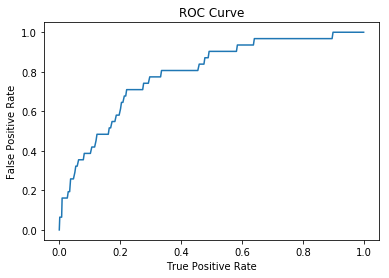

Training set areaUnderROC: 0.7897982622590632


In [111]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

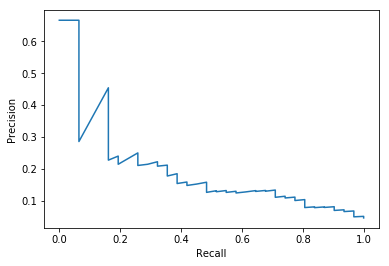

In [112]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [113]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(test)

In [124]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName = 'areaUnderPR')
evaluator.evaluate(predictions)

0.05393310753916797

In [125]:
evaluator.getMetricName() 
# The recommendation is to use F1, but the Spark docs only have that for multiclass classification

'areaUnderPR'

In [116]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [117]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [119]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing


In [121]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)

In [122]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.5916193181818169

In [127]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.01, 0.05, 0.1, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.05, 0.1, 0.25])
             .addGrid(lr.maxIter, [5, 10, 25])
             .build())


cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
trainingSummary = cvModel.summary
print('Training set AUC: ' + str(trainingSummary.areaUnderPR))

# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)
print('Test set AUC: ' + str(evaluator.evaluate(predictions)))

# Print best model info
print('Model Intercept: ', cvModel.bestModel.intercept)

KeyboardInterrupt: 

In [129]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')

# Create ParamGrid for Cross Validation tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 8])
             .addGrid(rf.maxBins, [12, 24])
             .addGrid(rf.numTrees, [10, 25])
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
trainingSummary = cvModel.summary
print('Training set AUC: ' + str(trainingSummary.areaUnderPR))

# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)
print('Test set AUC: ' + str(evaluator.evaluate(predictions)))

# Print best model info
cvModel.bestModel

KeyboardInterrupt: 